In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dunestyle.matplotlib as dunestyle
from scipy.interpolate import interp1d
from matplotlib import colors 

DUNE plot style enabled


In [2]:
FluxRotValues = np.array([[+0.9877, -0.1564, +0.0000],  # new x axis in old coordinates: be nice and fix things (ends up the same)
                        [+0.0000, +0.0000, +1.0000],  # new y axis in old coordinates: vertical
                        [-0.1564, -0.9877, +0.0000]])   # new z axis in old coordinates: away from Batavia, IL

Inverse_FluxRotValues = np.linalg.inv(FluxRotValues)

In [3]:
# Read the file
bartol_solmax_tenGeV = np.loadtxt('TotalFlux_EvtDistr_theta_Bartol_solmax_NuFIT4p1_NO_hA_BR_TenGeV.txt')
honda_solmax_tenGeV = np.loadtxt('TotalFlux_EvtDistr_theta_Honda_solmax_NuFIT4p1_NO_hA_BR_OneHundredGeV.txt')

# Split into two arrays
cosrange = bartol_solmax_tenGeV[:, 0][1:-1]
dndthetab = bartol_solmax_tenGeV[:, 1][1:-1]
dndthetah = honda_solmax_tenGeV[:, 1][1:-1]


In [4]:
def log_interp1d(x, y, kind='linear'):
    """
    Logarithmic interpolation for y while keeping x linear.
    """
    y = np.clip(y, 1e-10, None)  # Avoid issues with zeros or negatives in y
    logy = np.log10(y)
    lin_interp = interp1d(x, logy, kind=kind, bounds_error=False, fill_value="extrapolate")
    return lambda z: np.power(10.0, lin_interp(z))

In [5]:
theta_inter_b = log_interp1d(cosrange,dndthetab)
theta_inter_h = log_interp1d(cosrange,dndthetah)
cos_linear = np.linspace(-1,1,100001)

In [6]:
dndtheta_interp_b = [theta_inter_b(cos) for cos in cos_linear]
dndtheta_interp_h = [theta_inter_h(cos) for cos in cos_linear]

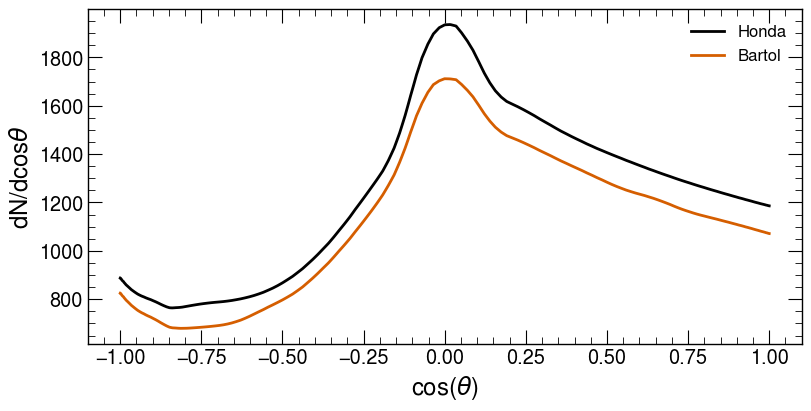

In [7]:
fig, axs = plt.subplots(1, 1, figsize=(8, 4), constrained_layout=True)
plt.step(cos_linear,dndtheta_interp_h, label = 'Honda')
plt.step(cos_linear,dndtheta_interp_b, label = 'Bartol')
plt.ylabel(r'dN/dcos$\theta$')
plt.xlabel(r'cos($\theta$)')
plt.legend()
plt.show()

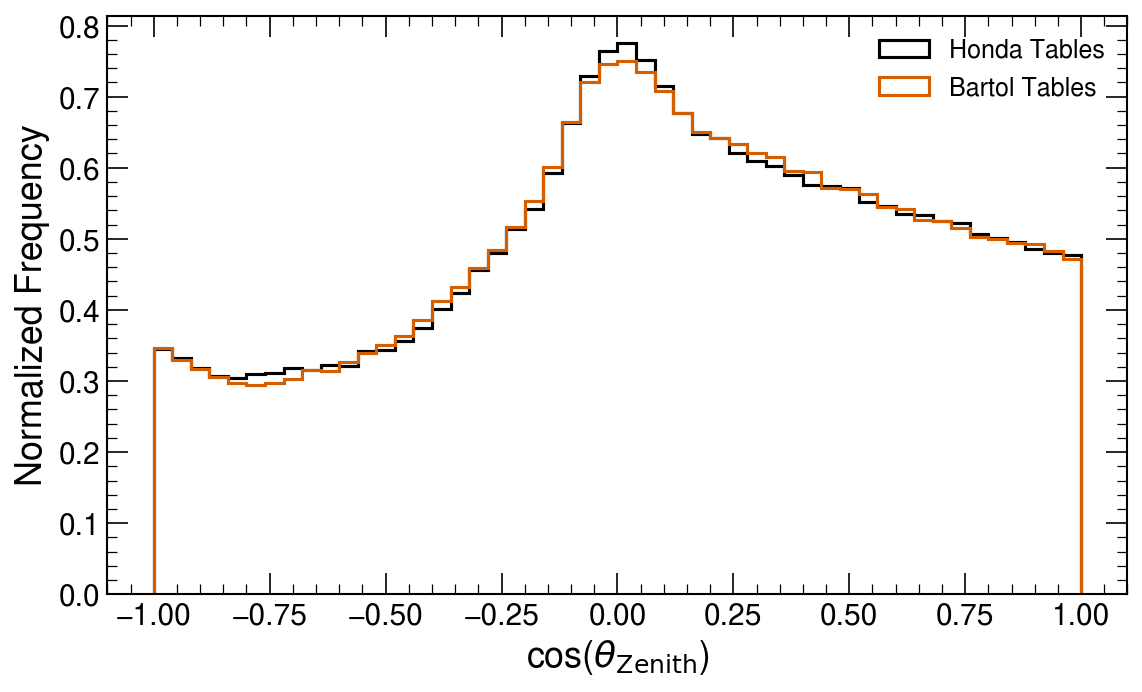

In [8]:

# Normalize y to create a PDF
pdf_b = dndtheta_interp_b / np.trapz(dndtheta_interp_b, cos_linear)  # Normalize using integration (area under the curve)
pdf_h = dndtheta_interp_h / np.trapz(dndtheta_interp_h, cos_linear)  # Normalize using integration (area under the curve)

# Compute the CDF
cdf_b = np.cumsum(pdf_b * np.diff(np.append(cos_linear, cos_linear[-1] + (cos_linear[-1] - cos_linear[-2]))))  # Scale by dx for CDF
cdf_b /= cdf_b[-1]  # Normalize CDF to end at 1

cdf_h = np.cumsum(pdf_h * np.diff(np.append(cos_linear, cos_linear[-1] + (cos_linear[-1] - cos_linear[-2]))))  # Scale by dx for CDF
cdf_h /= cdf_h[-1]  # Normalize CDF to end at 1

# Function to sample from the PDF
def sample_from_pdf(x, cdf, size=1000):
    random_values = np.random.uniform(0, 1, size)
    sampled_indices = np.searchsorted(cdf, random_values)
    return x[sampled_indices]

# Sample random values
sampled_values_b = sample_from_pdf(cos_linear, cdf_b, size=1000000)
samples_costheta_simu = np.loadtxt('samples_costheta_all.txt')
sampled_values_h = sample_from_pdf(cos_linear, cdf_h, size=1000000)
samples_costheta_reco = np.loadtxt('samples_costheta_reco.txt')
# Plot the original PDF

plt.figure(dpi=150, figsize=(7.5, 4.5),constrained_layout=True)
#plt.plot(cos_linear, pdf_h, label="PDF - Honda")
#plt.plot(cos_linear, pdf_b, label="PDF - Bartol")

# Plot a histogram of sampled values
plt.hist(sampled_values_h, bins=50, histtype='step', density=True, label="Honda Tables")
plt.hist(sampled_values_b, bins=50, histtype='step', density=True, label="Bartol Tables")
#plt.hist(-samples_costheta_simu, bins=50, histtype='step', density=True, label="Samples A&E Hist Sim")
#plt.hist(-samples_costheta_reco, bins=50, histtype='step', density=True, label="Samples A&E Hist Reco")


# Labels and legend
plt.xlabel(r"cos($\theta_{\text{Zenith}}$)")
plt.ylabel("Normalized Frequency")
plt.legend()
plt.savefig('../AngularStudiesPlots/CosZenith_dist_TablesFlux.png', format='png', dpi=300)
plt.savefig('../AngularStudiesPlots/CosZenith_dist_TablesFlux.pdf', format='pdf', dpi=300)
plt.show()

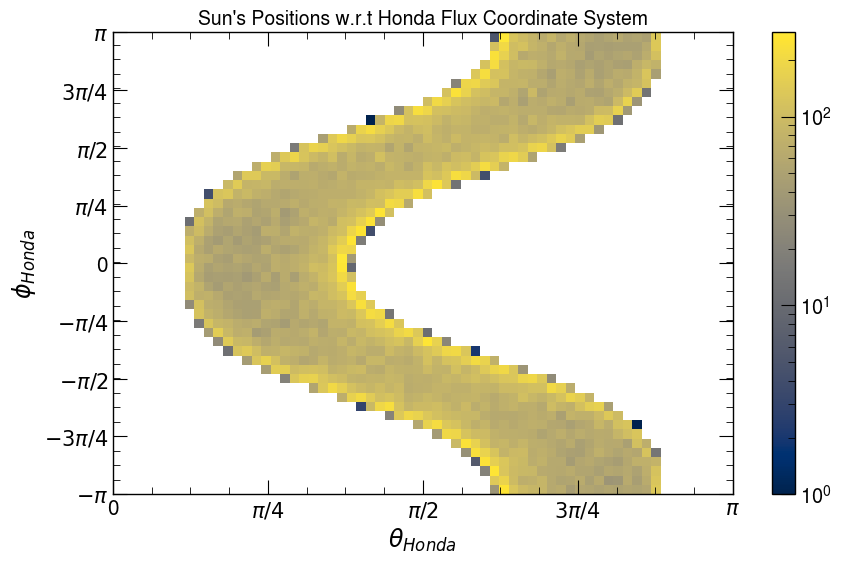

In [9]:
import math
Sun_Positions = np.loadtxt('../../Optimization/background_sun_pos.dat', delimiter='\t', usecols=(0,1,2))
PlotSunDirection = []
SunPosInHondaCoorS = [Inverse_FluxRotValues.dot(SunPos)  for SunPos in Sun_Positions] 
Phi_Theta_NuMom_Unit = [PlotSunDirection.append((math.atan2(SunPos[1], SunPos[0]), math.acos(SunPos[2]))) for SunPos in SunPosInHondaCoorS] 
fig, ax = plt.subplots(dpi=100, figsize=(10, 6))
PlotSunDirection = np.array(PlotSunDirection)
h = ax.hist2d(PlotSunDirection[:,1],PlotSunDirection[:,0], bins = (50,50),  norm = colors.LogNorm(), label = ' # Events')
ax.set_xlabel(r'$\theta_{Honda}$', fontsize = 17)
ax.set_ylabel(r'$\phi_{Honda}$', fontsize = 17)
ax.set_xticks([0.0,0.78539,1.570,2.356,3.14159])
ax.set_xticklabels([0,r'$\pi / 4$',r'$\pi / 2$', r'$3 \pi / 4$', r'$\pi$'], fontsize = 15)
ax.set_yticks([-3.14559,-2.356,-1.570,-0.78539,0.0,0.78539,1.570,2.356,3.14159])
ax.set_yticklabels([r'$-\pi$',r'$ -3\pi / 4$', r'$-\pi / 2$', r'$-\pi / 4$',0,r'$\pi / 4$',r'$\pi / 2$', r'$3 \pi / 4$', r'$\pi$'], fontsize = 15)
fig.colorbar(h[3], ax=ax)
plt.title("Sun's Positions w.r.t Honda Flux Coordinate System", fontsize=14)
#plt.savefig('AngularStudiesPlots/SunPositions_HondaCoordSys.pdf', format='pdf', dpi=300)
#plt.savefig('AngularStudiesPlots/SunPositions_HondaCoordSys.png', format='png', dpi=300)
plt.show()

In [10]:
samples_theta_simu = np.loadtxt('samples_theta_all.txt')
samples_theta_reco = np.loadtxt('samples_theta_reco.txt')

PhiBartolUnif = 2*np.pi*np.random.random_sample((sampled_values_b.size,))-np.pi
PhiHondaUnif = 2*np.pi*np.random.random_sample((sampled_values_h.size,))-np.pi
PhiSampleRecoUnif = 2*np.pi*np.random.random_sample((samples_theta_reco.size,))-np.pi
PhiSampleSimuUnif = 2*np.pi*np.random.random_sample((samples_theta_simu.size,))-np.pi

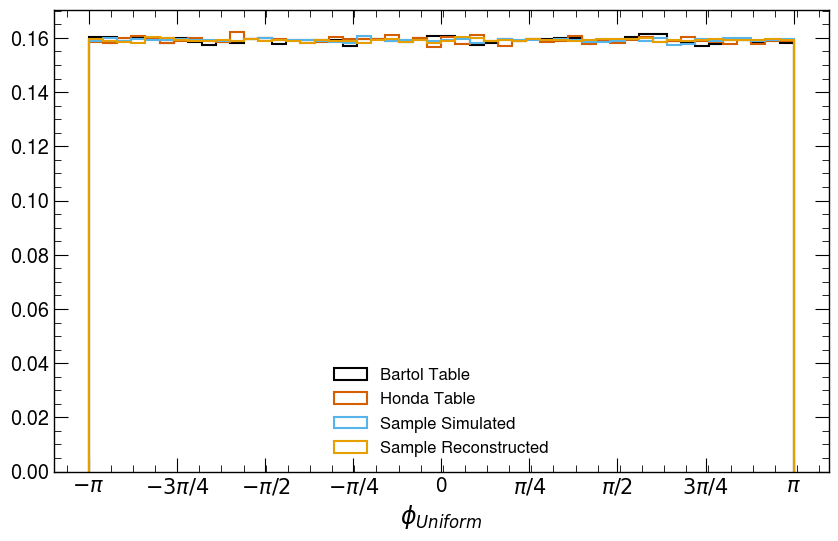

In [11]:
fig, ax = plt.subplots(dpi=100, figsize=(10, 6))
ax.hist(PhiBartolUnif, bins = 50,histtype = 'step', density=1, label = 'Bartol Table')
ax.hist(PhiHondaUnif, bins = 50,histtype = 'step', density=1, label = 'Honda Table')
ax.hist(PhiSampleRecoUnif, bins = 50,histtype = 'step', density=1, label = 'Sample Simulated')
ax.hist(PhiSampleSimuUnif, bins = 50,histtype = 'step', density=1, label = 'Sample Reconstructed')

#plt.title(r'Uniform $\phi$ Distribution to try to reproduce a Bartol Scenario')
ax.set_xticks([-3.14559,-2.356,-1.570,-0.78539,0.0,0.78539,1.570,2.356,3.14159])
ax.set_xticklabels([r'$-\pi$',r'$ -3\pi / 4$', r'$-\pi / 2$', r'$-\pi / 4$',0,r'$\pi / 4$',r'$\pi / 2$', r'$3 \pi / 4$', r'$\pi$'], fontsize = 15)
ax.set_xlabel(r'$\phi_{Uniform}$', fontsize = 17)
plt.legend()
#plt.savefig('AngularStudiesPlots/UniformPhiTest.pdf', format='pdf', dpi=300)
#plt.savefig('AngularStudiesPlots/UniformPhiTest.png', format='png', dpi=300)
plt.show()

In [12]:
plot_dirdetc_nu_phiBartolIso = np.vstack((PhiBartolUnif, np.arccos(sampled_values_b))).T
plot_dirdetc_nu_phiHondaIso = np.vstack((PhiHondaUnif, np.arccos(sampled_values_h))).T
plot_dirdetc_nu_phiSimuIso = np.vstack((PhiSampleSimuUnif,samples_theta_simu )).T
plot_dirdetc_nu_phiRecoIso = np.vstack((PhiSampleRecoUnif,samples_theta_reco)).T

In [13]:
def cosineAngle_wSphericalUnitVec(a,b):
    return np.sin(a[1])*np.sin(b[1])*np.cos(a[0]-b[0])+np.cos(a[1])*np.cos(b[1])

def compute_cosine_histogram(plot_dirdetc_nu_phi, PlotSunDirection):
    """
    Computes cosine angles between atmospheric events and sampled sun positions.
    
    Parameters:
    plot_dirdetc_nu_phi : list
        List of atmospheric event vectors.
    PlotSunDirection : list
        List of sun direction vectors.
    cosineAngle_wSphericalUnitVec : function
        Function to compute cosine angle between two vectors.
        
    Returns:
    list
        Histogram of cosine angles.
    """
    hist_cos_PhiUnif = []
    
    for index, atmevt in enumerate(plot_dirdetc_nu_phi):
        indices = np.random.randint(0, len(PlotSunDirection), size=1)
        # Use the sampled indices to select elements from the array
        sample_sunpos = PlotSunDirection[indices]
        #print(sample_sunpos[0])
        for sunpos in sample_sunpos:
            hist_cos_PhiUnif.append(cosineAngle_wSphericalUnitVec(atmevt,sample_sunpos[0]))
    return hist_cos_PhiUnif

In [14]:
hist_cos_BartolCoordSys_PhiUnif = compute_cosine_histogram(plot_dirdetc_nu_phiBartolIso, PlotSunDirection)
hist_cos_HondaCoordSys_PhiUnif = compute_cosine_histogram(plot_dirdetc_nu_phiHondaIso, PlotSunDirection)
hist_cos_SimCoordSys_PhiUnif = compute_cosine_histogram(plot_dirdetc_nu_phiSimuIso, PlotSunDirection)
hist_cos_RecoCoordSys_PhiUnif = compute_cosine_histogram(plot_dirdetc_nu_phiRecoIso, PlotSunDirection)

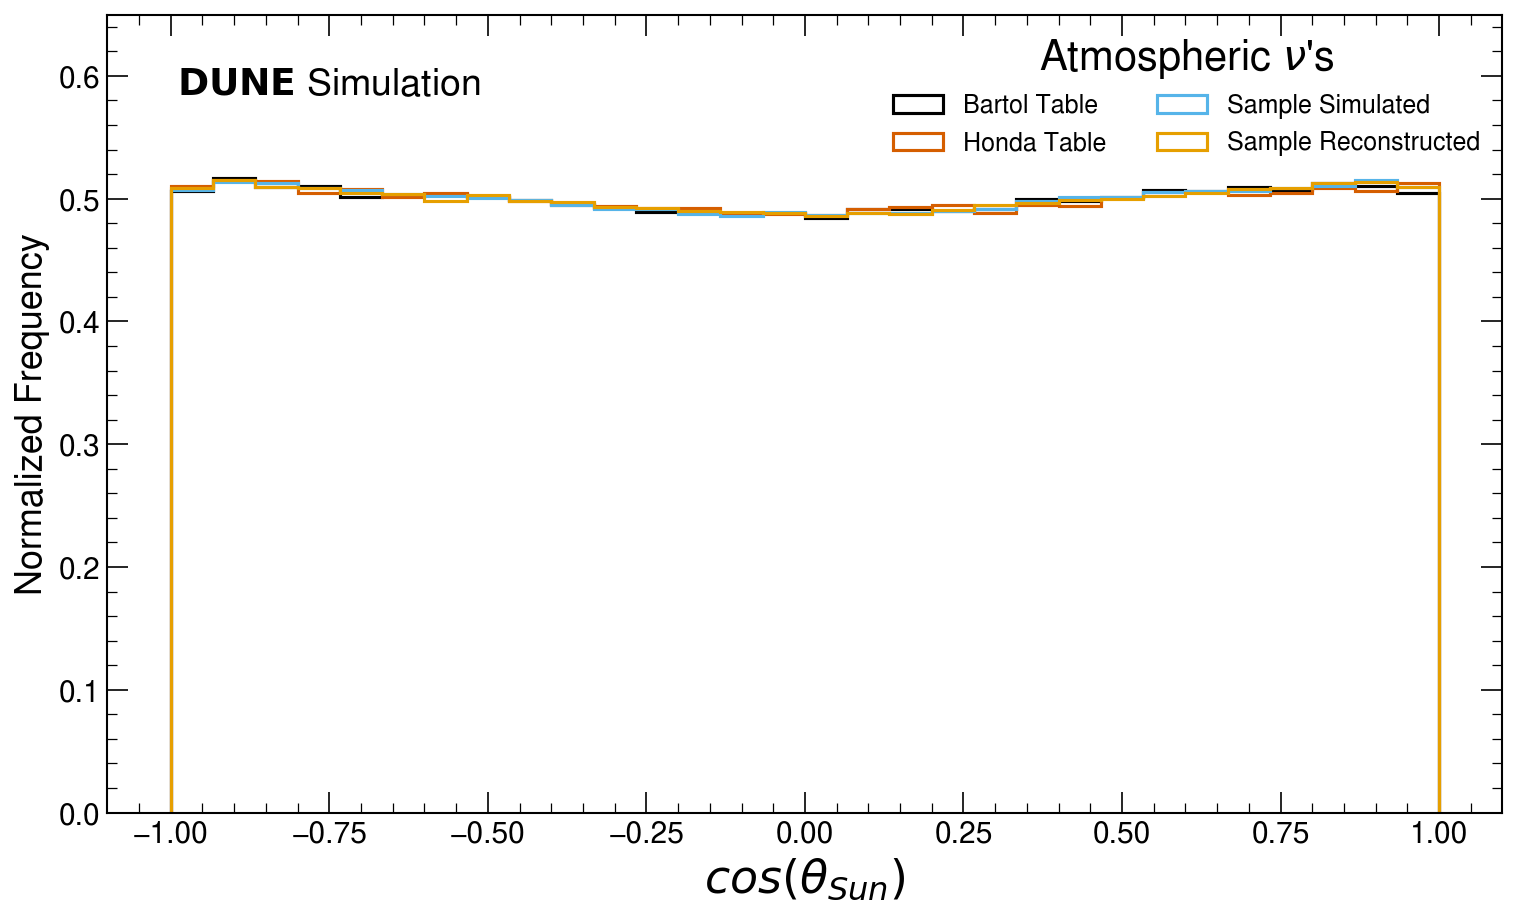

In [15]:
fig, ax = plt.subplots(dpi=150, figsize=(10, 6), constrained_layout=True)
plt.hist(hist_cos_BartolCoordSys_PhiUnif, bins = 30,histtype = 'step', density = 1,label = 'Bartol Table')
plt.hist(hist_cos_HondaCoordSys_PhiUnif, bins = 30,histtype = 'step', density = 1,label = 'Honda Table' )
plt.hist(hist_cos_SimCoordSys_PhiUnif, bins = 30,histtype = 'step', density = 1,label = 'Sample Simulated')
plt.hist(hist_cos_RecoCoordSys_PhiUnif, bins = 30,histtype = 'step', density = 1,label = 'Sample Reconstructed')
#plt.title(r'Cosine of Bartol Neutrino Direction w.r.t Sun', textsize =12)
plt.ylabel('Normalized Frequency')
plt.ylim([0.0,0.65])
plt.legend(title=r"Atmospheric $\nu$'s", title_fontsize=20 , ncols =2)
dunestyle.Simulation()
plt.xlabel(r'$cos(\theta_{Sun})$',fontsize = 22)
plt.savefig('../AngularStudiesPlots/CosSun_dist_TablesFlux.png', format='png', dpi=300)
plt.savefig('../AngularStudiesPlots/CosSun_dist_TablesFlux.pdf', format='pdf', dpi=300)
plt.show()

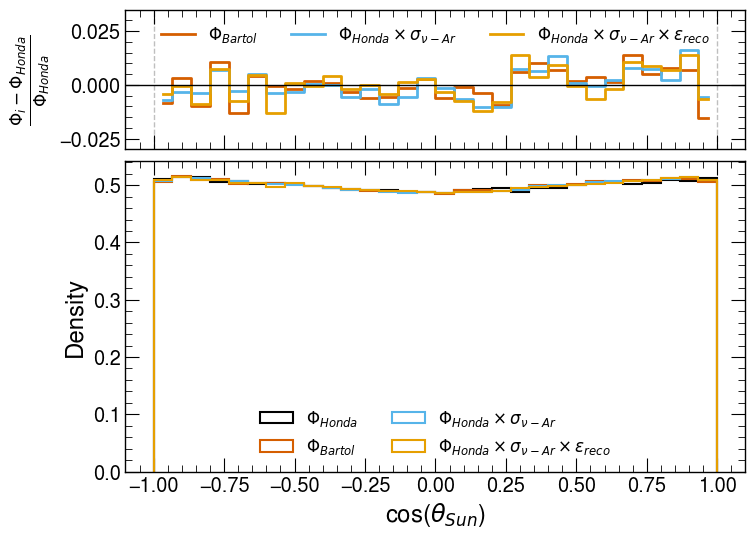

In [19]:
import numpy as np
import matplotlib.pyplot as plt

honda  = np.asarray(hist_cos_HondaCoordSys_PhiUnif)
bartol = np.asarray(hist_cos_BartolCoordSys_PhiUnif)
sim    = np.asarray(hist_cos_SimCoordSys_PhiUnif)
reco   = np.asarray(hist_cos_RecoCoordSys_PhiUnif)

bins = 30
xmin = min(honda.min(), bartol.min(), sim.min(), reco.min())
xmax = max(honda.max(), bartol.max(), sim.max(), reco.max())
edges   = np.linspace(xmin, xmax, bins + 1)
centers = 0.5 * (edges[:-1] + edges[1:])

# density histograms (same as ax.hist(..., density=True))
h_honda,  _ = np.histogram(honda,  bins=edges, density=True)
h_bartol, _ = np.histogram(bartol, bins=edges, density=True)
h_sim,    _ = np.histogram(sim,    bins=edges, density=True)
h_reco,   _ = np.histogram(reco,   bins=edges, density=True)

# relative diffs
rel_bartol = np.divide(h_bartol - h_honda, h_honda, out=np.zeros_like(h_honda, float), where=h_honda != 0)
rel_sim    = np.divide(h_sim    - h_honda, h_honda, out=np.zeros_like(h_honda, float), where=h_honda != 0)
rel_reco   = np.divide(h_reco   - h_honda, h_honda, out=np.zeros_like(h_honda, float), where=h_honda != 0)

# --- Plot ---
fig, (ax_up, ax_down) = plt.subplots(
    2, 1, sharex=True,
    gridspec_kw={"height_ratios": [9,20], "hspace": 0.05},
    figsize=(8, 6)
)

cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
c_honda  = "k"
c_bartol = cycle[1]
c_sim    = cycle[2]
c_reco   = cycle[3]

# Top: relative difference (match colors to bottom)
ax_up.axvline(-1., color="k", lw=1, ls='--',alpha = 0.25)
ax_up.axvline(1., color="k", lw=1, ls='--',alpha = 0.25)
ax_up.step(centers, rel_bartol, where="mid", color=c_bartol, label=rf"$\Phi_{{Bartol}}$")
ax_up.step(centers, rel_sim,    where="mid", color=c_sim,    label=rf"$\Phi_{{Honda}} \times \sigma_{{\nu-Ar}}$")
ax_up.step(centers, rel_reco,   where="mid", color=c_reco,   label=rf"$\Phi_{{Honda}} \times \sigma_{{\nu-Ar}} \times \epsilon_{{reco}}$")
ax_up.axhline(0, color="k", lw=1)
ax_up.set_ylabel(rf"$\frac{{\Phi_i - \Phi_{{Honda}}}} {{\Phi_{{Honda}}}}$")
ax_up.tick_params(labelbottom=False)
ax_up.legend(ncols=3, fontsize=12, loc='upper center')
ax_up.set_ylim(-0.03, 0.035)

# Bottom: histograms (Honda black)
ax_down.hist(honda,  bins=edges, histtype="step", density=True, color=c_honda,  label=rf"$\Phi_{{Honda}}$")
ax_down.hist(bartol, bins=edges, histtype="step", density=True, color=c_bartol, label=rf"$\Phi_{{Bartol}}$")
ax_down.hist(sim,    bins=edges, histtype="step", density=True, color=c_sim,    label=rf"$\Phi_{{Honda}} \times \sigma_{{\nu-Ar}}$")
ax_down.hist(reco,   bins=edges, histtype="step", density=True, color=c_reco,   label=rf"$\Phi_{{Honda}} \times \sigma_{{\nu-Ar}} \times \epsilon_{{reco}}$")

ax_down.set_xlabel(rf"cos($\theta_{{Sun}}$)")
ax_down.set_ylabel("Density")
ax_down.legend(ncols=2)

plt.show()


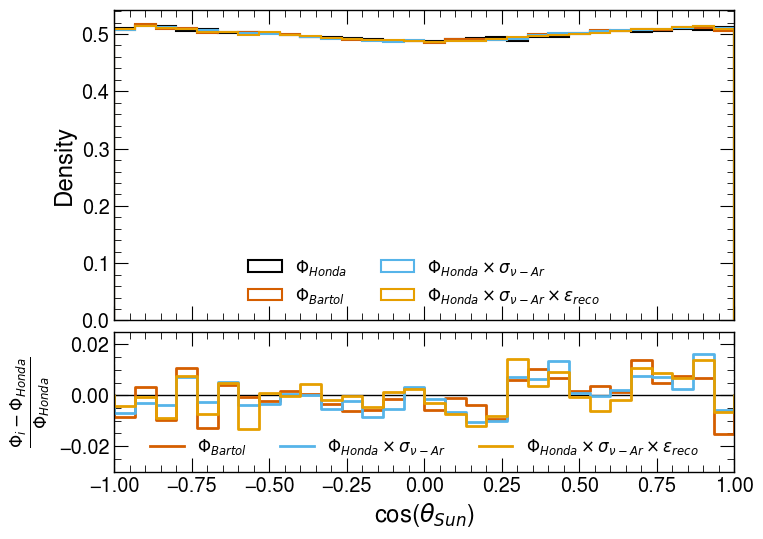

In [45]:
import numpy as np
import matplotlib.pyplot as plt

honda  = np.asarray(hist_cos_HondaCoordSys_PhiUnif)
bartol = np.asarray(hist_cos_BartolCoordSys_PhiUnif)
sim    = np.asarray(hist_cos_SimCoordSys_PhiUnif)
reco   = np.asarray(hist_cos_RecoCoordSys_PhiUnif)

bins = 30
xmin = min(honda.min(), bartol.min(), sim.min(), reco.min())
xmax = max(honda.max(), bartol.max(), sim.max(), reco.max())
edges = np.linspace(-1, 1, bins + 1)
centers = 0.5*(edges[:-1] + edges[1:])


# density histograms (same as ax.hist(..., density=True))
h_honda,  _ = np.histogram(honda,  bins=edges, density=True)
h_bartol, _ = np.histogram(bartol, bins=edges, density=True)
h_sim,    _ = np.histogram(sim,    bins=edges, density=True)
h_reco,   _ = np.histogram(reco,   bins=edges, density=True)

# relative diffs
rel_bartol = np.divide(h_bartol - h_honda, h_honda, out=np.zeros_like(h_honda, float), where=h_honda != 0)
rel_sim    = np.divide(h_sim    - h_honda, h_honda, out=np.zeros_like(h_honda, float), where=h_honda != 0)
rel_reco   = np.divide(h_reco   - h_honda, h_honda, out=np.zeros_like(h_honda, float), where=h_honda != 0)

# consistent colors (Honda black)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
c_honda  = "k"
c_bartol = cycle[1]
c_sim    = cycle[2]
c_reco   = cycle[3]

# --- Plot: TOP = distributions, BOTTOM = relative differences ---
fig, (ax_top, ax_bot) = plt.subplots(
    2, 1, sharex=True,
    gridspec_kw={"height_ratios": [20, 9], "hspace": 0.05},
    figsize=(8, 6)
)



# Top: histograms (Honda black)
ax_top.hist(honda,  bins=edges, histtype="step", density=True, color=c_honda,
            label=rf"$\Phi_{{Honda}}$")
ax_top.hist(bartol, bins=edges, histtype="step", density=True, color=c_bartol,
            label=rf"$\Phi_{{Bartol}}$")
ax_top.hist(sim,    bins=edges, histtype="step", density=True, color=c_sim,
            label=rf"$\Phi_{{Honda}} \times \sigma_{{\nu-Ar}}$")
ax_top.hist(reco,   bins=edges, histtype="step", density=True, color=c_reco,
            label=rf"$\Phi_{{Honda}} \times \sigma_{{\nu-Ar}} \times \epsilon_{{reco}}$")

ax_top.set_ylabel("Density")
ax_top.legend(ncols=2, loc='lower center')

ax_bot.axvline(-1., color="k", lw=1, ls='--',alpha = 0.25)
ax_bot.axvline(1., color="k", lw=1, ls='--',alpha = 0.25)

# Bottom: relative difference (match colors to top)
#ax_bot.step(centers, rel_bartol, where="mid", color=c_bartol, label=rf"$\Phi_{{Bartol}}$")
#ax_bot.step(centers, rel_sim,    where="mid", color=c_sim,    label=rf"$\Phi_{{Honda}} \times \sigma_{{\nu-Ar}}$")
#ax_bot.step(centers, rel_reco,   where="mid", color=c_reco,   label=rf"$\Phi_{{Honda}} \times \sigma_{{\nu-Ar}} \times \epsilon_{{reco}}$")
ax_bot.axhline(0, color="k", lw=1)

# pad one bin on each side so the step reaches -1 and +1
d = centers[1] - centers[0]  # uniform binning here

x_pad = np.r_[centers[0] - d, centers, centers[-1] + d]

rel_b_pad = np.r_[0.0, rel_bartol, 0.0]
rel_s_pad = np.r_[0.0, rel_sim,    0.0]
rel_r_pad = np.r_[0.0, rel_reco,   0.0]

ax_bot.step(x_pad, rel_b_pad, where="mid", color=c_bartol, label=rf"$\Phi_{{Bartol}}$")
ax_bot.step(x_pad, rel_s_pad, where="mid", color=c_sim,    label=rf"$\Phi_{{Honda}} \times \sigma_{{\nu-Ar}}$")
ax_bot.step(x_pad, rel_r_pad, where="mid", color=c_reco,   label=rf"$\Phi_{{Honda}} \times \sigma_{{\nu-Ar}} \times \epsilon_{{reco}}$")

ax_bot.set_xlim(edges[0], edges[-1])  # e.g. -1 to +1 if edges are set that way




ax_bot.set_xlabel(rf"cos($\theta_{{Sun}}$)")
ax_bot.set_ylabel(rf"$\frac{{\Phi_i - \Phi_{{Honda}}}} {{\Phi_{{Honda}}}}$")
ax_bot.set_ylim(-0.03, 0.025)
ax_bot.legend(ncols=3, fontsize=12, loc="lower center")

plt.show()


In [ ]:


def areas_in_out(density, edges, cut_left, cut_right):
    """
    Aout = area inside [cut_left, cut_right]      (BACKGROUND)
    Ain  = area outside that window               (SIGNAL)

    Aout = area of the background region
    Ain  = area of the signal region
    Atot = total area

    Total area normalization check: Ain + Aout = Atot
    ---------------

    """
    density = np.asarray(density, dtype=float)
    edges   = np.asarray(edges, dtype=float)

    widths  = np.diff(edges)
    centers = 0.5 * (edges[:-1] + edges[1:])

    # enforce ordering
    cut_left, cut_right = sorted((cut_left, cut_right))

    in_window = (centers >= cut_left) & (centers <= cut_right)

    Aout = np.sum(density[in_window]   * widths[in_window])    # BACKGROUND (inside)
    Ain  = np.sum(density[~in_window]  * widths[~in_window])   # SIGNAL (outside)
    Atot = Ain + Aout
    return Ain, Aout, Atot

def frac_in(density, edges, cut_left, cut_right):
    ain, aout, atot = areas_in_out(density, edges, cut_left, cut_right)
    return np.nan if atot == 0 else ain / aout  # fraction in signal region

def s_over_b(density, edges, cut_left, cut_right):
    ain, aout, atot = areas_in_out(density, edges, cut_left, cut_right)
    return np.nan if aout == 0 else ain / aout   # signal/background ratio

OptimalAngCuts = np.loadtxt(
    '../../Optimization/Optimization_DefaultNuclearModel_final/Eff_Bkg_index_00a.txt',
    usecols=(1,2,4), skiprows=1
)

labelsamples = ["b1p1_m05","b1p1_m10","b1p1_m20","b1p1_m40",
                "b1p5_m05","b1p5_m10","b1p5_m20","b1p5_m40",
                "b10_m05","b10_m10","b10_m20","b10_m40"]

def rel(x, ref):
    return np.nan if ref == 0 else (x - ref)/ref

for index in range(len(labelsamples)):
    cut_a = OptimalAngCuts[index][0]
    cut_b = OptimalAngCuts[index][1]
    cut_left, cut_right = sorted((cut_a, cut_b))

    print('----------------------------------------')
    print(f"Sample: {labelsamples[index]}")
    print("cut_left, cut_right =", cut_left, cut_right)

    for name, h in [("Honda", h_honda), ("Bartol", h_bartol), ("Sim", h_sim), ("Reco", h_reco)]:
        ain, aout, atot = areas_in_out(h, edges, cut_left, cut_right)
        print(f"{name:6s}  Ain(signal)={ain:.4f}  Aout(bkg)={aout:.4f}  Atot={atot:.4f}")

    f_honda  = frac_in(h_honda,  edges, cut_left, cut_right)
    f_bartol = frac_in(h_bartol, edges, cut_left, cut_right)
    f_sim    = frac_in(h_sim,    edges, cut_left, cut_right)
    f_reco   = frac_in(h_reco,   edges, cut_left, cut_right)

    print("Fraction in signal window:")
    print("Honda :", f_honda)
    print("Bartol:", f_bartol, "  rel diff:", rel(f_bartol, f_honda))
    print("Sim  :", f_sim,    "  rel diff:", rel(f_sim, f_honda))
    print("Reco :", f_reco,   "  rel diff:", rel(f_reco, f_honda))
    print()



----------------------------------------
Sample: b1p1_m05
cut_left, cut_right = -0.9 0.9
Honda   Ain(signal)=0.1018  Aout(bkg)=0.8982  Atot=1.0000
Bartol  Ain(signal)=0.1020  Aout(bkg)=0.8980  Atot=1.0000
Sim     Ain(signal)=0.1022  Aout(bkg)=0.8978  Atot=1.0000
Reco    Ain(signal)=0.1023  Aout(bkg)=0.8977  Atot=1.0000
Fraction in signal window:
Honda : 0.11329936285877464
Bartol: 0.11359690687323148   rel diff: 0.0026261755313463837
Sim  : 0.11382112945474597   rel diff: 0.004605203266868378
Reco : 0.11394255897787545   rel diff: 0.005676961483910039

----------------------------------------
Sample: b1p1_m10
cut_left, cut_right = -0.9 0.9
Honda   Ain(signal)=0.1018  Aout(bkg)=0.8982  Atot=1.0000
Bartol  Ain(signal)=0.1020  Aout(bkg)=0.8980  Atot=1.0000
Sim     Ain(signal)=0.1022  Aout(bkg)=0.8978  Atot=1.0000
Reco    Ain(signal)=0.1023  Aout(bkg)=0.8977  Atot=1.0000
Fraction in signal window:
Honda : 0.11329936285877464
Bartol: 0.11359690687323148   rel diff: 0.0026261755313463837
Sim